<a href="https://colab.research.google.com/github/mokraneimed/TensorFlow-projects/blob/main/text_emotion_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 4.6 MB/s 
     |████████████████████████████████| 212 kB 66.1 MB/s 


In [ ]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.9.1


In [ ]:
dataset = nlp.load_dataset('emotion')

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [ ]:
dataset

{'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [ ]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [ ]:
tweets = [x['text'] for x in train]

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer = Tokenizer(num_words = 10000 , oov_token = '<UKN>')
tokenizer.fit_on_texts(tweets)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
def get_sequences (tokenizer , tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded = pad_sequences(sequences , truncating='post',padding='post',maxlen=50)
    return padded



In [ ]:
padded_train = get_sequences(tokenizer,tweets)

In [ ]:
padded_train[1]

array([   2,   40,  101,   60,    8,   15,  494,    5,   15, 3496,  553,
         32,   60,   61,  128,  148,   76, 1480,    4,   22, 1255,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

In [ ]:
labels = [x['label'] for x in train]

In [ ]:
classes =set( [x['label'] for x in train])

In [ ]:
classes

{'anger', 'fear', 'joy', 'love', 'sadness', 'surprise'}

In [ ]:
class_to_index = dict((c,i) for i,c in enumerate(classes))

In [ ]:
class_to_index

{'joy': 0, 'surprise': 1, 'sadness': 2, 'love': 3, 'fear': 4, 'anger': 5}

In [ ]:
labels

In [ ]:
names_to_ids = lambda labels:([class_to_index.get(x) for x in labels])

In [ ]:
train_labels = names_to_ids(labels)

In [ ]:
train_labels

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000,16,input_length= 50),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences=True),),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    
    tf.keras.layers.Dense(6,activation='softmax')
])
model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
) 

In [ ]:
model.summary()

In [ ]:
val_tweets = [x['text'] for x in val]
val_seq = get_sequences(tokenizer,val_tweets)
val_labels = [x['label'] for x in val]
val_labels = names_to_ids(val_labels)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_accuracy',mode='min',verbose=1,patience=21)

In [ ]:
padded_train =np.array(padded_train)
train_labels = np.array(train_labels)
val_seq = np.array(val_seq)
val_labels = np.array(val_labels)

In [ ]:
h = model.fit(
    padded_train,train_labels,
    validation_data=(val_seq,val_labels),
    epochs=18,
    callbacks = [early_stop]
)

Epoch 1/18
500/500 [==============================] - 17s 17ms/step - loss: 1.3561 - accuracy: 0.4782 - val_loss: 0.8938 - val_accuracy: 0.6745
Epoch 2/18
500/500 [==============================] - 6s 13ms/step - loss: 0.6186 - accuracy: 0.7804 - val_loss: 0.5148 - val_accuracy: 0.8245
Epoch 3/18
500/500 [==============================] - 6s 13ms/step - loss: 0.3078 - accuracy: 0.9022 - val_loss: 0.3823 - val_accuracy: 0.8700
Epoch 4/18
500/500 [==============================] - 7s 14ms/step - loss: 0.1933 - accuracy: 0.9394 - val_loss: 0.3706 - val_accuracy: 0.8750
Epoch 5/18
500/500 [==============================] - 7s 13ms/step - loss: 0.1217 - accuracy: 0.9613 - val_loss: 0.3750 - val_accuracy: 0.8840
Epoch 6/18
500/500 [==============================] - 6s 13ms/step - loss: 0.1087 - accuracy: 0.9657 - val_loss: 0.3970 - val_accuracy: 0.8905
Epoch 7/18
500/500 [==============================] - 6s 13ms/step - loss: 0.0845 - accuracy: 0.9744 - val_loss: 0.3700 - val_accuracy: 0.890

In [ ]:
test_tweets = [x['text']for x in test]
padded = get_sequences(tokenizer,test_tweets)
test_label = [x['label'] for x in test]
test_labels = names_to_ids(test_label)

In [ ]:
padded = np.array(padded)
test_labels = np.array(test_labels)

In [ ]:
_=model.evaluate(padded ,test_labels)

63/63 [==============================] - 0s 7ms/step - loss: 0.4656 - accuracy: 0.8895


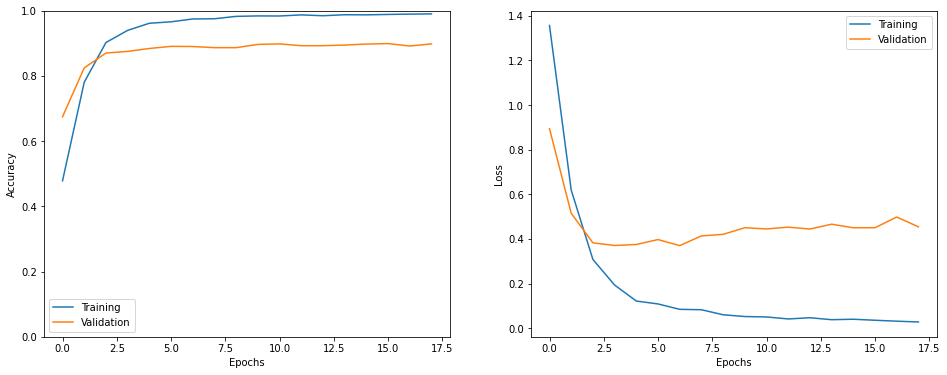

In [ ]:
show_history(h)

In [ ]:
test_tweets[146],test_label[146]


('i am feeling eager to start doing some work the man who works there literally says so uhm you guys want to go in back and see if we can find anything to do',
 'joy')

In [ ]:
preds = model.predict(np.expand_dims(padded[146],axis=0))[0]

In [ ]:
preds

array([9.9899751e-01, 3.5757376e-04, 1.6777631e-05, 6.5953136e-06,
       5.4181123e-04, 7.9695339e-05], dtype=float32)

{'anger': 4, 'fear': 5, 'joy': 1, 'love': 3, 'sadness': 0, 'surprise': 2}